In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_json('recipes.json')

In [3]:
type(df['Instructions'][2])

str

In [4]:
eval_df = df[11000:]
eval_df.shape

(1190, 8)

In [5]:
df = df[:11000]
df.shape

(11000, 8)

In [6]:
import spacy
nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])

In [7]:
tokenized = [nlp(t) for t in df.Instructions.values]

In [17]:
type(tokenized[111])

spacy.tokens.doc.Doc

In [8]:
vocab = {"<UNK>": 1, "<PAD>": 0}
for txt in tokenized:
    for token in txt:
        if token.text not in vocab.keys():
            vocab[token.text] = len(vocab)
print("Number of unique tokens: {}".format(len(vocab)))

Number of unique tokens: 17687


In [9]:
type(df['Ingredients'].values)

numpy.ndarray

In [10]:
ingredients = df['Ingredients']
type(ingredients[0])

list

In [11]:
for i in ingredients[0]:
#     for t in nlp(i):
#         if _filter(t) and len(_clean(t.text)) >= 2:
#             _clean(t.text)
    print(i)

600 g Hackfleisch, halb und halb
800 g Sauerkraut
200 g Wurst, geräucherte (Csabai Kolbász)
150 g Speck, durchwachsener, geräucherter
100 g Reis
1 m.-große Zwiebel(n)
1 Zehe/n Knoblauch
2 Becher Schmand
1/2TL Kümmel, ganzer
2 Lorbeerblätter
Salz und Pfeffer
4 Ei(er) (bei Bedarf)
Paprikapulver
etwas Wasser
Öl


In [12]:
def _filter(token):
    if len(token) < 2:
        return False
    if token.is_stop:
        return False
    if token.text[0].islower():
        return False
    if token.is_digit:
        return False
    if token.like_num:
        return False
    return True

In [13]:
def _clean(text):
    text = text.replace("(", "")
    text = text.split("/")[0]
    return text

In [14]:
clean = [_clean(t.text) for i in ingredients[214] for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
clean

['Rosenkohl',
 'Schalotten',
 'Hühnerbrühe',
 'Milch',
 'EL',
 'Crème',
 'Speck',
 'Kartoffelgnocchi']

/Users/mattosoerick/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
W0804 17:31:56.287582 4648748480 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 17:31:56.468930 4648748480 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype

1.14.0
2.2.4-tf


W0804 17:31:56.513185 4648748480 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 17:31:56.516562 4648748480 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 17:31:56.525350 4648748480 deprecation.py:506] From /Users/mattosoerick/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensor

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          884350    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 50)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         58880     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           129       
Total params: 1,042,175
Trainable params: 1,042,175
Non-trainable params: 0
______________________________________________

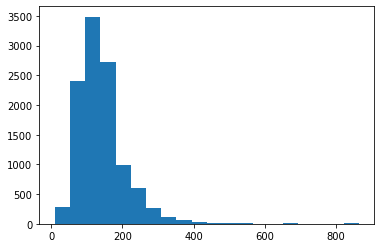

In [15]:
def get_labels(ingredients, tokenized_instructions):
    labels = []
    for ing, ti in zip(ingredients, tokenized_instructions):
        l_i = []
        ci = [_clean(t.text) for i in ing for t in nlp(i) if _filter(t) and len(_clean(t.text)) >= 2]
        label = []
        for token in ti:
            l_i.append(any((c == token.text or c == token.text[:-1] or c[:-1] == token.text) for c in ci))
        labels.append(l_i)
    return labels

labels = get_labels(ingredients, tokenized)

set([t.text for t, l in zip(tokenized[214], labels[214]) if l])

import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len([t for t in tokens]) for tokens in tokenized], bins=20);

MAX_LEN = 400

from keras.preprocessing.sequence import pad_sequences

def prepare_sequences(texts, max_len, vocab={"<UNK>": 1, "<PAD>": 0}):
    X = [[vocab.get(w.text, vocab["<UNK>"]) for w in s] for s in texts]
    return pad_sequences(maxlen=max_len, sequences=X, padding="post", value=vocab["<PAD>"])

X_seq = prepare_sequences(tokenized, max_len=MAX_LEN, vocab=vocab)

X_seq[1]

y_seq = []
for l in labels:
    y_i = []
    for i in range(MAX_LEN):
        try:
            y_i.append(float(l[i]))
        except:
            y_i.append(0.0)
    y_seq.append(np.array(y_i))
y_seq = np.array(y_seq)
y_seq = y_seq.reshape(y_seq.shape[0], y_seq.shape[1], 1)

import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)


model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=len(vocab), mask_zero=True, output_dim=50))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(units=64, return_sequences=True)))
model.add(layers.TimeDistributed(layers.Dense(1, activation='sigmoid')))


model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
